<a href="https://colab.research.google.com/github/Tanusri06/Brain-Tumor-VIT-Comparison/blob/main/notebooks/Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

print("Please upload the kaggle.json file from your computer.")
files.upload()

Please upload the kaggle.json file from your computer.


Saving kaggle(1).json to kaggle(1).json


{'kaggle(1).json': b'{"username":"tanusric","key":"b25518ec837965f339c1335ca5ed0975"}'}

In [2]:
# (Optional) Rename the uploaded file to the standard 'kaggle.json'
# This helps avoid errors if you downloaded the key more than once.
# The quotes are important because of the space and parentheses.
!mv -f "kaggle(1).json" "kaggle.json"

# Create a directory to store the API key
!mkdir -p ~/.kaggle

# Move the key to that directory
!mv kaggle.json ~/.kaggle/

# Set the correct file permissions for the key
!chmod 600 ~/.kaggle/kaggle.json

# Now, download and unzip the specific dataset you chose
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content/dataset --unzip


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 98% 146M/149M [00:00<00:00, 1.53GB/s]
100% 149M/149M [00:00<00:00, 1.52GB/s]


In [3]:
!ls /content/dataset/Training

glioma	meningioma  notumor  pituitary


In [4]:
import os
import torch
import timm
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [5]:
# --- Configuration ---
DATA_DIR = '/content/dataset/Training/'
TEST_DIR = '/content/dataset/Testing/' # The unseen data for final evaluation
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20 # You can adjust this number

# --- Data Loading Function ---
def load_data(data_dir):
    image_paths = []
    labels = []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}

    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])

    df = pd.DataFrame({'filepath': image_paths, 'label': labels})
    return df, label_map

# --- Load and Split the Data ---
train_val_df, label_map = load_data(DATA_DIR)
test_df, _ = load_data(TEST_DIR)

# Split the main data into training and validation sets
train_df, val_df = train_test_split(
    train_val_df, test_size=0.2, random_state=42, stratify=train_val_df['label']
)

print("Data loaded and split successfully:")
print(f"Label map: {label_map}")
print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

Data loaded and split successfully:
Label map: {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
Training samples: 4569
Validation samples: 1143
Test samples: 1311


In [6]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Transformation for training data (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Transformation for validation and test data (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Custom PyTorch Dataset Class
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepath']
        label = self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Create the datasets
train_dataset = TumorDataset(train_df, transform=train_transform)
val_dataset = TumorDataset(val_df, transform=val_test_transform)
test_dataset = TumorDataset(test_df, transform=val_test_transform)

# Create the DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("DataLoaders are ready.")


DataLoaders are ready.


In [7]:
def train_model(model, model_name, train_loader, val_loader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
    best_val_accuracy = 0.0

    print(f"--- Starting Training for {model_name} ---")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        print(f"\nEpoch {epoch+1}/{epochs}")
        for images, labels in tqdm(train_loader, desc="Training"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        correct_val = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                correct_val += (predicted == labels).sum().item()

        val_accuracy = correct_val / len(val_loader.dataset)
        print(f"Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            save_path = f'/content/{model_name}_best.pth'
            torch.save(model.state_dict(), save_path)
            print(f"----> New best model saved to {save_path}")

    print(f"\nFinished Training for {model_name}!")
    return best_val_accuracy

In [8]:
# --- Train Swin Transformer ---
swin_model_name = 'swin_base_patch4_window7_224'

# Create the Swin model using the 'timm' library
swin_model = timm.create_model(
    swin_model_name,
    pretrained=True,
    num_classes=len(label_map) # Set the output to our 4 classes
)
swin_model.to(device) # Move the model to the GPU

# Call the function you defined in the previous stage to start training
print(f"--- Starting Training for {swin_model_name} ---")
swin_accuracy = train_model(
    model=swin_model,
    model_name=swin_model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=1e-5
)

# Print the final result
print(f"\nBest Validation Accuracy for Swin Transformer: {swin_accuracy:.4f}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

--- Starting Training for swin_base_patch4_window7_224 ---
--- Starting Training for swin_base_patch4_window7_224 ---

Epoch 1/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.66it/s]


Validation Accuracy: 0.9239
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 2/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9615
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 3/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9799
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 4/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9834
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 5/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9843
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 6/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.64it/s]


Validation Accuracy: 0.9851
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 7/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9904
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 8/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9921
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 9/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9895

Epoch 10/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]


Validation Accuracy: 0.9895

Epoch 11/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9913

Epoch 12/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.60it/s]


Validation Accuracy: 0.9930
----> New best model saved to /content/swin_base_patch4_window7_224_best.pth

Epoch 13/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.62it/s]


Validation Accuracy: 0.9869

Epoch 14/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]


Validation Accuracy: 0.9895

Epoch 15/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9913

Epoch 16/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9886

Epoch 17/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]


Validation Accuracy: 0.9913

Epoch 18/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.66it/s]


Validation Accuracy: 0.9895

Epoch 19/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.63it/s]


Validation Accuracy: 0.9878

Epoch 20/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.65it/s]

Validation Accuracy: 0.9886

Finished Training for swin_base_patch4_window7_224!

Best Validation Accuracy for Swin Transformer: 0.9930


In [9]:
# --- Train DeiT Model ---
deit_model_name = 'deit_base_patch16_224'

# Create the DeiT model from the 'timm' library
deit_model = timm.create_model(
    deit_model_name,
    pretrained=True,
    num_classes=len(label_map) # Set the output to our 4 classes
)
deit_model.to(device) # Move the model to the GPU

# Call the same training function, but with the new DeiT model
print(f"--- Starting Training for {deit_model_name} ---")
deit_accuracy = train_model(
    model=deit_model,
    model_name=deit_model_name,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=EPOCHS,
    learning_rate=1e-5
)

# Print the final result
print(f"\nBest Validation Accuracy for DeiT Transformer: {deit_accuracy:.4f}")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

--- Starting Training for deit_base_patch16_224 ---
--- Starting Training for deit_base_patch16_224 ---

Epoch 1/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.83it/s]


Validation Accuracy: 0.9379
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 2/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.78it/s]


Validation Accuracy: 0.9676
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 3/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.80it/s]


Validation Accuracy: 0.9755
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 4/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.82it/s]


Validation Accuracy: 0.9851
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 5/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.80it/s]


Validation Accuracy: 0.9886
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 6/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.78it/s]


Validation Accuracy: 0.9878

Epoch 7/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.80it/s]


Validation Accuracy: 0.9904
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 8/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.82it/s]


Validation Accuracy: 0.9703

Epoch 9/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.78it/s]


Validation Accuracy: 0.9886

Epoch 10/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.79it/s]


Validation Accuracy: 0.9895

Epoch 11/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.79it/s]


Validation Accuracy: 0.9860

Epoch 12/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.81it/s]


Validation Accuracy: 0.9843

Epoch 13/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.78it/s]


Validation Accuracy: 0.9904

Epoch 14/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.78it/s]


Validation Accuracy: 0.9886

Epoch 15/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.79it/s]


Validation Accuracy: 0.9913
----> New best model saved to /content/deit_base_patch16_224_best.pth

Epoch 16/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.79it/s]


Validation Accuracy: 0.9886

Epoch 17/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.81it/s]


Validation Accuracy: 0.9904

Epoch 18/20


Validation: 100%|██████████| 36/36 [00:13<00:00,  2.76it/s]


Validation Accuracy: 0.9904

Epoch 19/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.80it/s]


Validation Accuracy: 0.9895

Epoch 20/20


Validation: 100%|██████████| 36/36 [00:12<00:00,  2.79it/s]

Validation Accuracy: 0.9895

Finished Training for deit_base_patch16_224!

Best Validation Accuracy for DeiT Transformer: 0.9913


In [10]:
# Data Loading Function
def load_data(data_dir):
    image_paths, labels = [], []
    class_names = sorted(os.listdir(data_dir))
    label_map = {name: i for i, name in enumerate(class_names)}
    for class_name in class_names:
        class_dir = os.path.join(data_dir, class_name)
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(class_dir, filename))
                labels.append(label_map[class_name])
    return pd.DataFrame({'filepath': image_paths, 'label': labels}), label_map

# Load dataframes
train_val_df, label_map = load_data(DATA_DIR)
test_df, _ = load_data(TEST_DIR)

# Define Transformation
val_test_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Custom Dataset Class
class TumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df, self.transform = dataframe, transform
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        img_path, label = self.df.iloc[idx]['filepath'], self.df.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# Create the Test DataLoader
test_dataset = TumorDataset(test_df, transform=val_test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("Test data is loaded and ready for evaluation.")

Test data is loaded and ready for evaluation.


In [11]:
def evaluate_model(model_name, test_loader, label_map):
    print(f"\n======================================================")
    print(f"   Starting Evaluation for: {model_name}")
    print(f"======================================================")

    model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{model_name}_best.pth'
    try:
        model.load_state_dict(torch.load(model_path))
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}.")
        print("Please make sure you have run the training for this model OR that the saved .pth file has been uploaded to /content/.")
        return

    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = list(label_map.keys())
    print(f"\n--- Evaluation Report for {model_name} ---")
    print("Accuracy:", accuracy_score(all_preds, all_labels))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}'); plt.show()

model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

--- Starting Training for swin_tiny_patch4_window7_224 ---

Epoch 1/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.60it/s]


Validation Accuracy: 0.9108
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 2/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]


Validation Accuracy: 0.9388
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 3/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.86it/s]


Validation Accuracy: 0.9641
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 4/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.29it/s]


Validation Accuracy: 0.9685
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 5/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.33it/s]


Validation Accuracy: 0.9781
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 6/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.72it/s]


Validation Accuracy: 0.9746

Epoch 7/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.23it/s]


Validation Accuracy: 0.9773

Epoch 8/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.19it/s]


Validation Accuracy: 0.9834
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 9/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.88it/s]


Validation Accuracy: 0.9825

Epoch 10/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.29it/s]


Validation Accuracy: 0.9834

Epoch 11/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.32it/s]


Validation Accuracy: 0.9851
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 12/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.33it/s]


Validation Accuracy: 0.9869
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 13/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.17it/s]


Validation Accuracy: 0.9904
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 14/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.15it/s]


Validation Accuracy: 0.9843

Epoch 15/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]


Validation Accuracy: 0.9913
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 16/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.28it/s]


Validation Accuracy: 0.9895

Epoch 17/20


Validation: 100%|██████████| 36/36 [00:07<00:00,  5.08it/s]


Validation Accuracy: 0.9921
----> New best model saved to /content/swin_tiny_patch4_window7_224_best.pth

Epoch 18/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.28it/s]


Validation Accuracy: 0.9860

Epoch 19/20


Validation: 100%|██████████| 36/36 [00:06<00:00,  5.71it/s]


Validation Accuracy: 0.9886

Epoch 20/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.07it/s]


Validation Accuracy: 0.9886

Finished Training for swin_tiny_patch4_window7_224!

   Starting Evaluation for: swin_tiny_patch4_window7_224


Evaluating swin_tiny_patch4_window7_224: 100%|██████████| 41/41 [00:07<00:00,  5.28it/s]



--- Evaluation Report for swin_tiny_patch4_window7_224 ---
Accuracy: 0.9969488939740656

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.99      0.99       300
  meningioma       0.99      1.00      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           1.00      1311
   macro avg       1.00      1.00      1.00      1311
weighted avg       1.00      1.00      1.00      1311



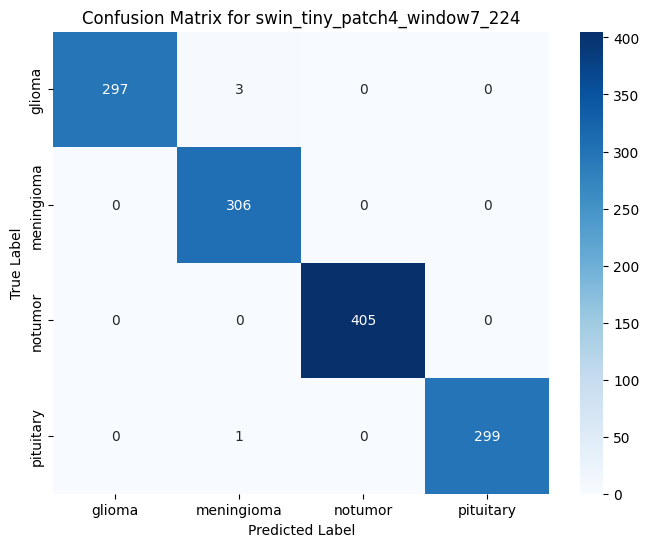

In [12]:
# --- Train and Evaluate Swin Transformer ---
swin_model_name = 'swin_tiny_patch4_window7_224'
swin_model = timm.create_model(swin_model_name, pretrained=True, num_classes=len(label_map))
swin_model.to(device)

# Train the model
train_model(swin_model, swin_model_name, train_loader, val_loader, EPOCHS, 1e-5)

# Immediately evaluate it on the test set
evaluate_model(swin_model_name, test_loader, label_map)

In [17]:
def evaluate_model(model_name, test_loader, label_map):
    print(f"\n======================================================")
    print(f"   Starting Evaluation for: {model_name}")
    print(f"======================================================")

    model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{model_name}_best.pth'
    try:
        model.load_state_dict(torch.load(model_path))
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {model_path}.")
        print("Please make sure you have run the training for this model OR that the saved .pth file has been uploaded to /content/.")
        return

    model.to(device)
    model.eval()

    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f"Evaluating {model_name}"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    class_names = list(label_map.keys())
    print(f"\n--- Evaluation Report for {model_name} ---")
    print("Accuracy:", accuracy_score(all_preds, all_labels))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label'); plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}'); plt.show()

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

--- Starting Training for deit_tiny_patch16_224 ---

Epoch 1/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.57it/s]


Validation Accuracy: 0.8933
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 2/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.88it/s]


Validation Accuracy: 0.9221
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 3/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.64it/s]


Validation Accuracy: 0.9589
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 4/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.34it/s]


Validation Accuracy: 0.9685
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 5/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.89it/s]


Validation Accuracy: 0.9799
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 6/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.96it/s]


Validation Accuracy: 0.9764

Epoch 7/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.84it/s]


Validation Accuracy: 0.9729

Epoch 8/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.52it/s]


Validation Accuracy: 0.9860
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 9/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.73it/s]


Validation Accuracy: 0.9781

Epoch 10/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.28it/s]


Validation Accuracy: 0.9790

Epoch 11/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.30it/s]


Validation Accuracy: 0.9851

Epoch 12/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Validation Accuracy: 0.9843

Epoch 13/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.63it/s]


Validation Accuracy: 0.9843

Epoch 14/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.35it/s]


Validation Accuracy: 0.9869
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 15/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.86it/s]


Validation Accuracy: 0.9878
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 16/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.69it/s]


Validation Accuracy: 0.9834

Epoch 17/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.81it/s]


Validation Accuracy: 0.9869

Epoch 18/20


Validation: 100%|██████████| 36/36 [00:05<00:00,  6.32it/s]


Validation Accuracy: 0.9860

Epoch 19/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.71it/s]


Validation Accuracy: 0.9904
----> New best model saved to /content/deit_tiny_patch16_224_best.pth

Epoch 20/20


Validation: 100%|██████████| 36/36 [00:04<00:00,  7.75it/s]


Validation Accuracy: 0.9851

Finished Training for deit_tiny_patch16_224!

   Starting Evaluation for: deit_tiny_patch16_224


Evaluating deit_tiny_patch16_224: 100%|██████████| 41/41 [00:05<00:00,  7.12it/s]



--- Evaluation Report for deit_tiny_patch16_224 ---
Accuracy: 0.984744469870328

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       300
  meningioma       0.94      1.00      0.97       306
     notumor       1.00      0.99      1.00       405
   pituitary       1.00      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.99      0.98      0.98      1311



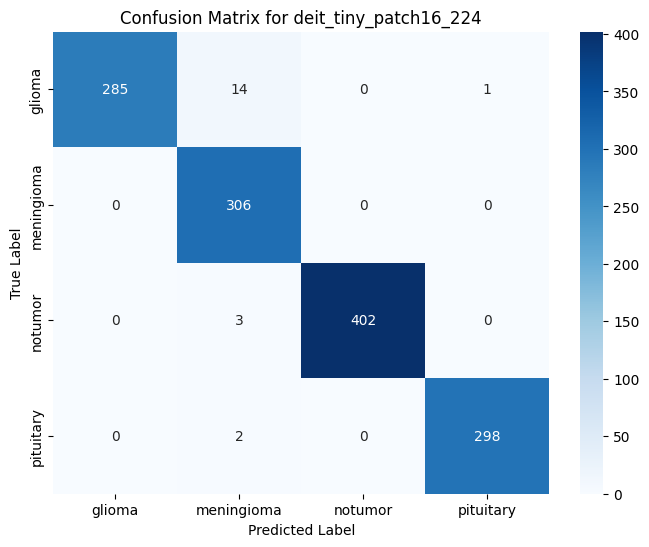

In [18]:
# --- Train and Evaluate DeiT Transformer ---
deit_model_name = 'deit_tiny_patch16_224'
deit_model = timm.create_model(deit_model_name, pretrained=True, num_classes=len(label_map))
deit_model.to(device)

# Train the model
train_model(deit_model, deit_model_name, train_loader, val_loader, EPOCHS, 1e-5)

# Immediately evaluate it on the test set
evaluate_model(deit_model_name, test_loader, label_map)

In [19]:
print("--- Starting Phase 2: Simple Fusion (Averaging) ---")

# --- Load All Your Trained Models ---
# IMPORTANT: Make sure the .pth files are in your /content/ directory.
# If they are not, you must run the training for them again, or upload them manually.
model_names = [
    'swin_tiny_patch4_window7_224',
    'deit_tiny_patch16_224'
    # Add 'deit_tiny_patch16_224' if you and your friend are combining results
]

models = []
for name in model_names:
    model = timm.create_model(name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{name}_best.pth'
    try:
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        model.eval()
        models.append(model)
        print(f"Successfully loaded {name}")
    except FileNotFoundError:
        print(f"ERROR: Could not find {model_path}. Please train this model first.")

# --- Run Fusion Evaluation ---
if len(models) == len(model_names):
    all_fused_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Running Fusion Evaluation"):
            images = images.to(device)
            all_labels.extend(labels.cpu().numpy())

            all_probs = []
            for model in models:
                outputs = model(images)
                probs = torch.nn.functional.softmax(outputs, dim=1)
                all_probs.append(probs)

            stacked_probs = torch.stack(all_probs)
            mean_probs = torch.mean(stacked_probs, dim=0)
            _, fused_preds = torch.max(mean_probs, 1)
            all_fused_preds.extend(fused_preds.cpu().numpy())

    # --- Print Evaluation Metrics for the Fused Model ---
    print("\n======================================================")
    print("   Evaluation Report for Fused (Ensemble) Model")
    print("======================================================")
    class_names = list(label_map.keys())
    print("Accuracy:", accuracy_score(all_labels, all_fused_preds))
    print("\nClassification Report:")
    print(classification_report(all_labels, all_fused_preds, target_names=class_names))



--- Starting Phase 2: Simple Fusion (Averaging) ---
Successfully loaded swin_tiny_patch4_window7_224
Successfully loaded deit_tiny_patch16_224


Running Fusion Evaluation: 100%|██████████| 41/41 [00:09<00:00,  4.33it/s]


   Evaluation Report for Fused (Ensemble) Model
Accuracy: 0.9931350114416476

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.97      1.00      0.99       306
     notumor       1.00      0.99      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [20]:
print("--- Starting Phase 3: Advanced Fusion (MLP) ---")
print("--- Step 3.2: Extracting Features ---")

# Load your trained models
model_names = ['swin_tiny_patch4_window7_224', 'deit_tiny_patch16_224']
models = []
for name in model_names:
    model = timm.create_model(name, pretrained=False, num_classes=len(label_map))
    model_path = f'/content/{name}_best.pth'
    model.load_state_dict(torch.load(model_path))
    # Remove the final classification layer to get the features
    model.reset_classifier(0)
    model.to(device)
    model.eval()
    models.append(model)

# Function to extract features
def extract_features(loader, models):
    all_features = []
    all_labels = []
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Extracting features"):
            images = images.to(device)

            # Get features from each model and concatenate them
            batch_features = [model(images) for model in models]
            concatenated_features = torch.cat(batch_features, dim=1)

            all_features.append(concatenated_features.cpu())
            all_labels.append(labels.cpu())

    return torch.cat(all_features), torch.cat(all_labels)

# Extract features for train, val, and test sets
train_features, train_labels = extract_features(train_loader, models)
val_features, val_labels = extract_features(val_loader, models)
test_features, test_labels = extract_features(test_loader, models)

print(f"\nFeature extraction complete. Shape of training features: {train_features.shape}")



--- Starting Phase 3: Advanced Fusion (MLP) ---
--- Step 3.2: Extracting Features ---


Extracting features: 100%|██████████| 41/41 [00:09<00:00,  4.54it/s]


Feature extraction complete. Shape of training features: torch.Size([4569, 960])


In [21]:
print("--- Step 3.3: Creating MLP DataLoaders ---")

# A simple Dataset for our features
class MLPDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create new datasets and dataloaders
mlp_train_dataset = MLPDataset(train_features, train_labels)
mlp_val_dataset = MLPDataset(val_features, val_labels)
mlp_test_dataset = MLPDataset(test_features, test_labels)

mlp_train_loader = DataLoader(mlp_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
mlp_val_loader = DataLoader(mlp_val_dataset, batch_size=BATCH_SIZE, shuffle=False)
mlp_test_loader = DataLoader(mlp_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("MLP DataLoaders are ready.")

--- Step 3.3: Creating MLP DataLoaders ---
MLP DataLoaders are ready.


In [22]:
print("--- Step 3.4: Defining and Training the MLP ---")

# Define a simple MLP
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout(out)
        out = self.fc2(out)
        return out

# Initialize and train the MLP
input_size = train_features.shape[1]
mlp_model = MLP(input_size, num_classes=len(label_map)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

# Simple training loop for the MLP
for epoch in range(25): # MLPs train very fast
    mlp_model.train()
    for features, labels in mlp_train_loader:
        features, labels = features.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = mlp_model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"MLP Epoch {epoch+1}/25, Loss: {loss.item():.4f}")

print("\nMLP training complete.")

# --- Step 3.5: Evaluate the MLP ---
mlp_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for features, labels in mlp_test_loader:
        features = features.to(device)
        outputs = mlp_model(features)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\n======================================================")
print("   Evaluation Report for MLP Fusion Model")
print("======================================================")
print("Accuracy:", accuracy_score(all_labels, all_preds))
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=label_map.keys()))

--- Step 3.4: Defining and Training the MLP ---
MLP Epoch 1/25, Loss: 0.0005
MLP Epoch 2/25, Loss: 0.0000
MLP Epoch 3/25, Loss: 0.0000
MLP Epoch 4/25, Loss: 0.0000
MLP Epoch 5/25, Loss: 0.0000
MLP Epoch 6/25, Loss: 0.0000
MLP Epoch 7/25, Loss: 0.0000
MLP Epoch 8/25, Loss: 0.0000
MLP Epoch 9/25, Loss: 0.0033
MLP Epoch 10/25, Loss: 0.0000
MLP Epoch 11/25, Loss: 0.0000
MLP Epoch 12/25, Loss: 0.0000
MLP Epoch 13/25, Loss: 0.0000
MLP Epoch 14/25, Loss: 0.0000
MLP Epoch 15/25, Loss: 0.0000
MLP Epoch 16/25, Loss: 0.0000
MLP Epoch 17/25, Loss: 0.0000
MLP Epoch 18/25, Loss: 0.0000
MLP Epoch 19/25, Loss: 0.0000
MLP Epoch 20/25, Loss: 0.0000
MLP Epoch 21/25, Loss: 0.0000
MLP Epoch 22/25, Loss: 0.0000
MLP Epoch 23/25, Loss: 0.0000
MLP Epoch 24/25, Loss: 0.0000
MLP Epoch 25/25, Loss: 0.0000

MLP training complete.

   Evaluation Report for MLP Fusion Model
Accuracy: 0.992372234935164

Classification Report:
              precision    recall  f1-score   support

      glioma       1.00      0.98    

In [23]:
!pip install grad-cam ttach

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 126.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=7317a050eddda05fd85364c6cbee5946a661cd8c737185bc703aaed720461826
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


--- Starting Phase 4: Explainable AI (XAI) ---


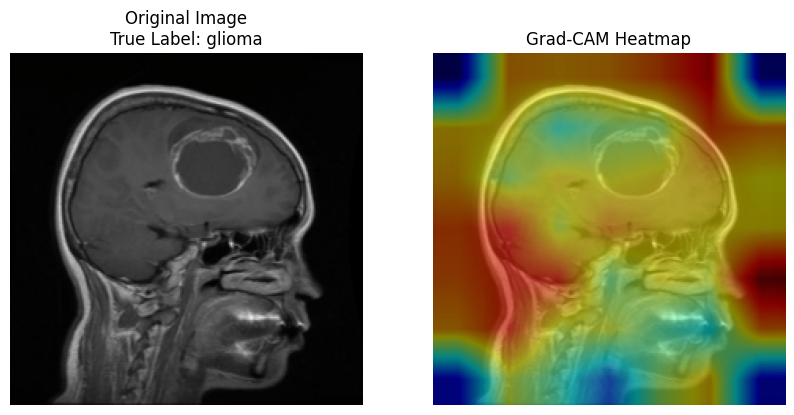

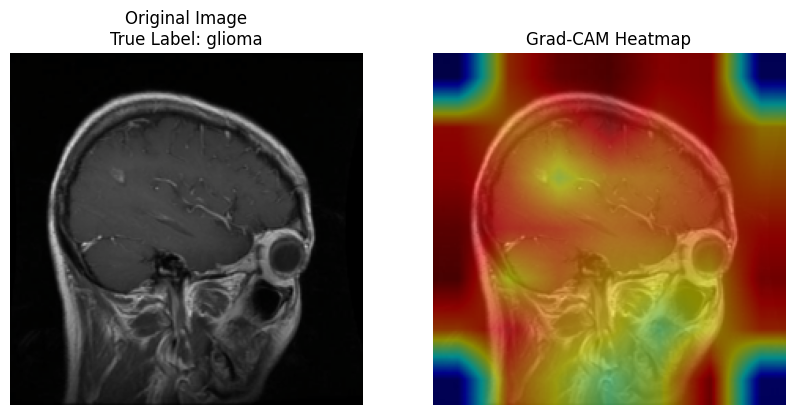

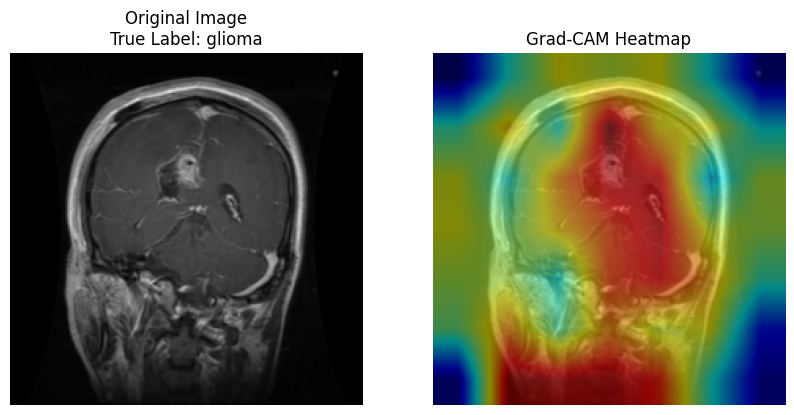

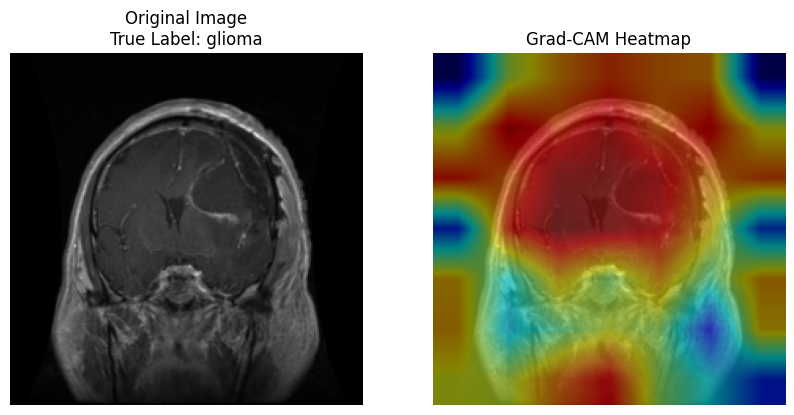

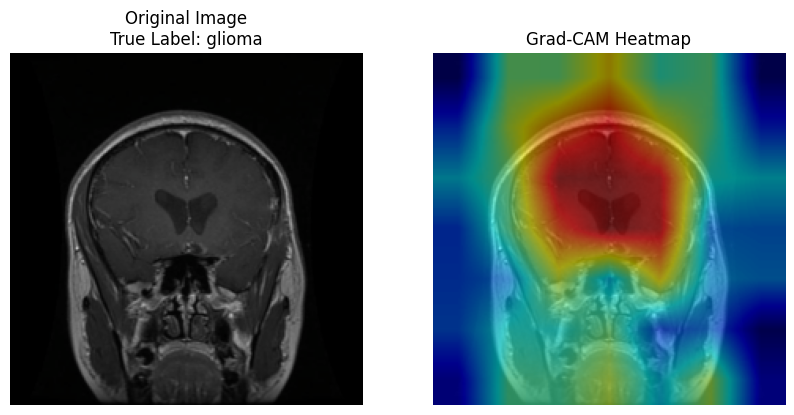

In [24]:
# ===================================================================
# CORRECTED ALL-IN-ONE CODE FOR PHASE 4 (XAI)
# ===================================================================

print("--- Starting Phase 4: Explainable AI (XAI) ---")
# Make sure the library is installed
!pip install grad-cam ttach -q

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2
import numpy as np

# --- Load your best trained model (e.g., Swin Transformer) ---
model_name = 'swin_tiny_patch4_window7_224'
model = timm.create_model(model_name, pretrained=False, num_classes=len(label_map))
model_path = f'/content/{model_name}_best.pth'
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()

# --- Define the target layer for visualization ---
target_layers = [model.layers[-1].blocks[-1].norm2]


# --- NEW: Define the reshape_transform function for Swin Transformer ---
# This function correctly reshapes the transformer's output for Grad-CAM
def reshape_transform(tensor, height=7, width=7):
    # The output of the Swin Transformer's last layer is not a 2D grid.
    # This function reshapes it to (batch_size, height, width, channels)
    result = tensor.reshape(tensor.size(0), height, width, tensor.size(2))

    # Bring channels to the second dimension (batch_size, channels, height, width)
    result = result.permute(0, 3, 1, 2)
    return result


# --- Get a few sample images from the test set ---
sample_images, sample_labels = next(iter(test_loader))
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)
class_names = list(label_map.keys())

# --- Generate and display heatmaps ---
# --- MODIFIED: Pass the reshape_transform to GradCAM ---
cam = GradCAM(model=model, target_layers=target_layers, reshape_transform=reshape_transform)

for i in range(5): # Visualize 5 images
    input_tensor = sample_images[i].unsqueeze(0)
    # Convert to a float32 numpy array for visualization
    rgb_img = inv_normalize(sample_images[i]).permute(1, 2, 0).cpu().numpy().astype(np.float32)

    targets = [ClassifierOutputTarget(sample_labels[i].item())]
    # The line below should now work correctly
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    grayscale_cam = grayscale_cam[0, :]

    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(rgb_img)
    plt.title(f"Original Image\nTrue Label: {class_names[sample_labels[i].item()]}")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(visualization)
    plt.title("Grad-CAM Heatmap")
    plt.axis('off')
    plt.show()